# 信用卡交易欺诈风险预测

### 数据来源：

* Kaggle数据集


* 匿名的信用卡交易数据，数据集中包含标签字段区分此交易是否是存在欺诈行为


* 出于用户隐私的保护的需要，数据中的V1-V28特征可能来自于对用户信息特征和其他敏感特征的主成分分析（PCA）结果


* 字段属性：

    Time： 交易发生时间
    
    V1-V28：PCA处理后的用户信息及其他敏感信息
    
    Amount：交易金额
    
    Class：交易类型标签；1：欺诈型交易；0：非欺诈型交易
    

### 学习目标：

#### 1）探索数据

* 要求：

  ① 读取数据表
  
  ② 查看数据的基本情况
  
#### 2）针对数据存在的问题，应该采取怎么样的特征工程？

* 要求：

  ① 分别查看交易金额和交易时间，并对这两列特征进行处理
  
  ② 查看V1-V28这些特征与因变量标签之间的关系
  
  ③ 对数据进行共线性筛查

#### 3）数据集是否存在分类不平衡的问题，如果存在应该如何解决？

* 要求：

  ① 查看数据标签类别分布是否平衡
  
  ② 如果存在不平衡的问题，对样本进行重取样（建议采取随机欠取样的方法），获得平衡分类的数据
  
  * 随机欠取样:抽取所有的总量较少的类别，然后对总量较多的类别进行随机抽样，抽取和总量较少类别一样多的样本，构成采样均匀的数据集

#### 4）如何进行模型数据预处理？

* 要求：

  ① 在平衡取样的数据集上对时间、金额特征进行标准化处理
  

#### 5）选取不同的模型进行模型训练并对比模型效果、优化模型效果，确定最终预测模型

* 要求：

  ① 使用留一法进行数据集划分，验证集比例：30%
  
  ② 选取至少两个不同类型的分类算法进行欺诈风险预测模型训练，并对比模型效果（kaggle数据提供方推荐以AUC值来评价模型），选出最佳模型
  

In [1]:
# 加载模块
# 数据读取与计算
import pandas as pd
import numpy as np
# 绘图
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # to do the grid of plots
%matplotlib inline
# 模型数据预处理
from sklearn.preprocessing import StandardScaler
# 数据集划分与参数搜索
from sklearn.model_selection import StratifiedKFold,train_test_split, GridSearchCV
# 训练模型
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# 模型整合
from sklearn.pipeline import Pipeline
# 模型指标查看
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
# 屏蔽warnings
import warnings
warnings.filterwarnings('ignore') 

### 数据初探

In [2]:
# 读取数据
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# 查看数据维度
df.shape

(284807, 31)

In [4]:
# 查看数据缺失情况
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### 特征工程

#### 1. 金额

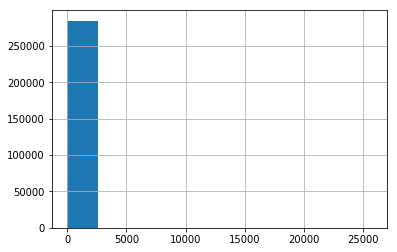

In [5]:
# 查看金额
df['Amount'].hist()

金额这个特征的分布存在非常明显的偏态分布

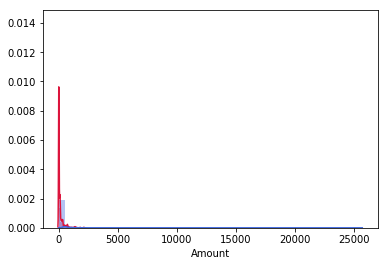

In [6]:
# 分类别查看金额的分布情况
sns.distplot(df['Amount'][df['Class'] == 1], bins = 50, color='#DC143C') # 红色
sns.distplot(df['Amount'][df['Class'] == 0], bins = 50, color='#4169E1') # 蓝色
plt.show()

针对这种分布情况，我们采取取对数的方式对这个特征进行纠偏

In [7]:
# 取log
df['Amount'] = df['Amount'].map(lambda x: np.log(x) if x>0 else 0)

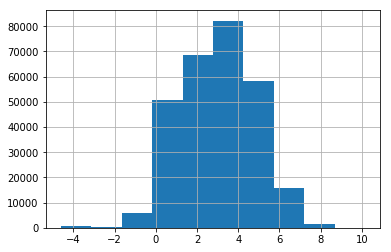

In [8]:
# 查看就偏后的数据分布
df['Amount'].hist()

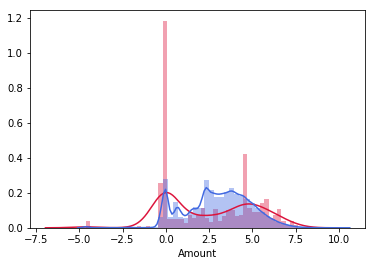

In [9]:
# 分别查看欺诈样本与非欺诈样本的金额数据分布
sns.distplot(df['Amount'][df['Class'] == 1], bins = 50, color='#DC143C') # 红色
sns.distplot(df['Amount'][df['Class'] == 0], bins = 50, color='#4169E1') # 蓝色
plt.show()

#### 2. 时间

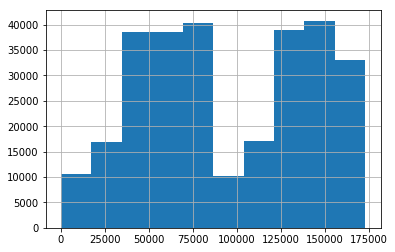

In [10]:
df['Time'].hist()

从时间的数据分布可以看出，数据集应该收集了两个完整的时间周期的数据，因此我们可以怎加一些时间特征

In [11]:
# 增加时间特征：小时、分钟
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_min'] = (timedelta.dt.components.minutes).astype(int)
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)

分别查看新增的时间特征与是有欺诈风险的关系

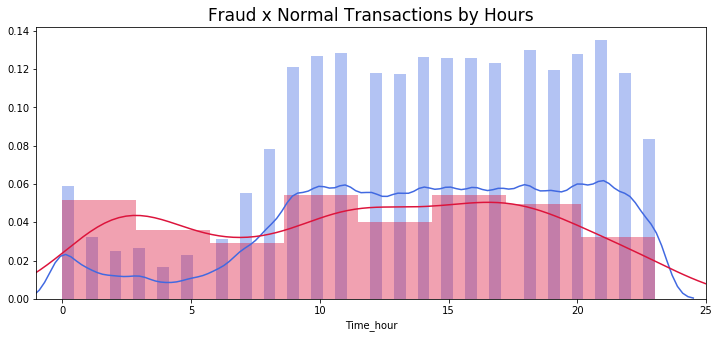

In [12]:
# 小时
plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_hour"], 
             color='#4169E1') # 蓝色
sns.distplot(df[df['Class'] == 1]["Time_hour"], 
             color='#DC143C') # 红色
plt.title('Fraud x Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()

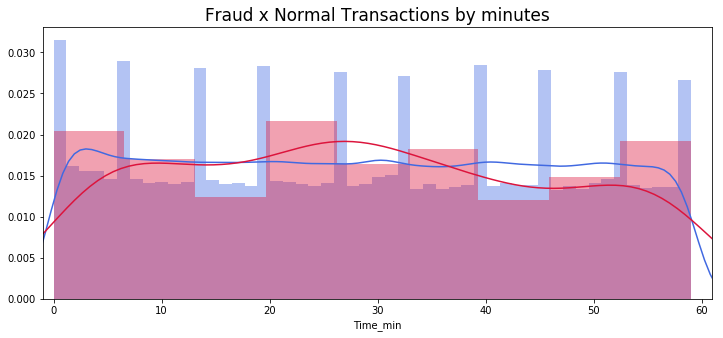

In [13]:
# 分钟
plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_min"], 
             color='#4169E1') # 蓝色
sns.distplot(df[df['Class'] == 1]["Time_min"], 
             color='#DC143C') # 红色
plt.title('Fraud x Normal Transactions by minutes', fontsize=17)
plt.xlim([-1,61])
plt.show()

#### 3. 其他
查看所有其他主成分特征与欺诈风险的关系

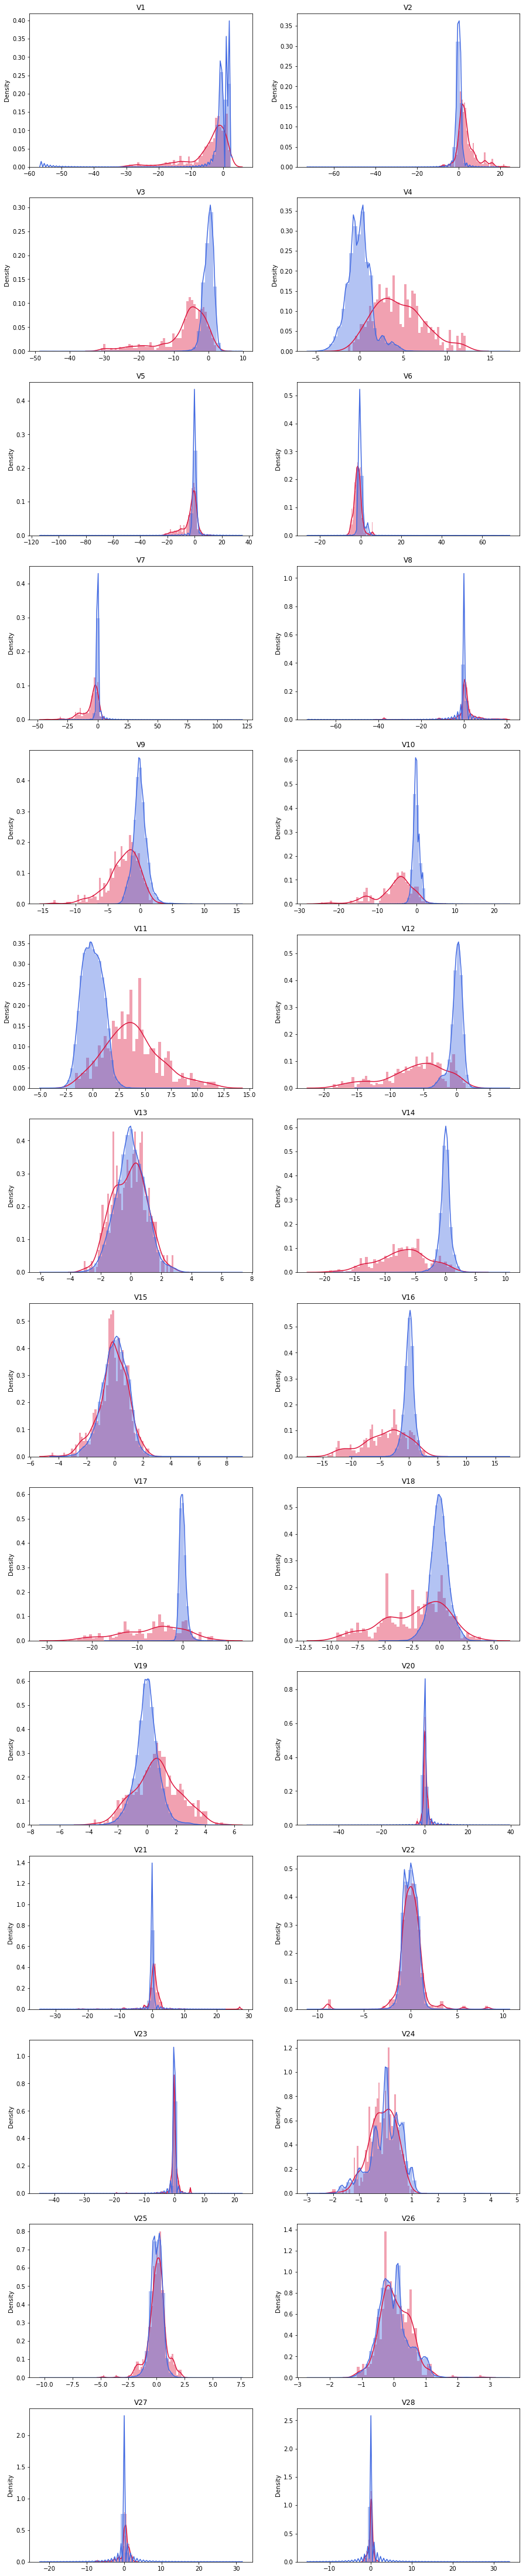

In [14]:
columns = [f'V{i}' for i in range(1,29)]

grid = gridspec.GridSpec(14, 2)
plt.figure(figsize=(15,20*4))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[col][df['Class'] == 1], bins = 50, color='#DC143C') # 红色
    sns.distplot(df[col][df['Class'] == 0], bins = 50, color='#4169E1') # 蓝色
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
plt.show()

#### 4. 共线性筛查

查看所有特征的相关性矩阵

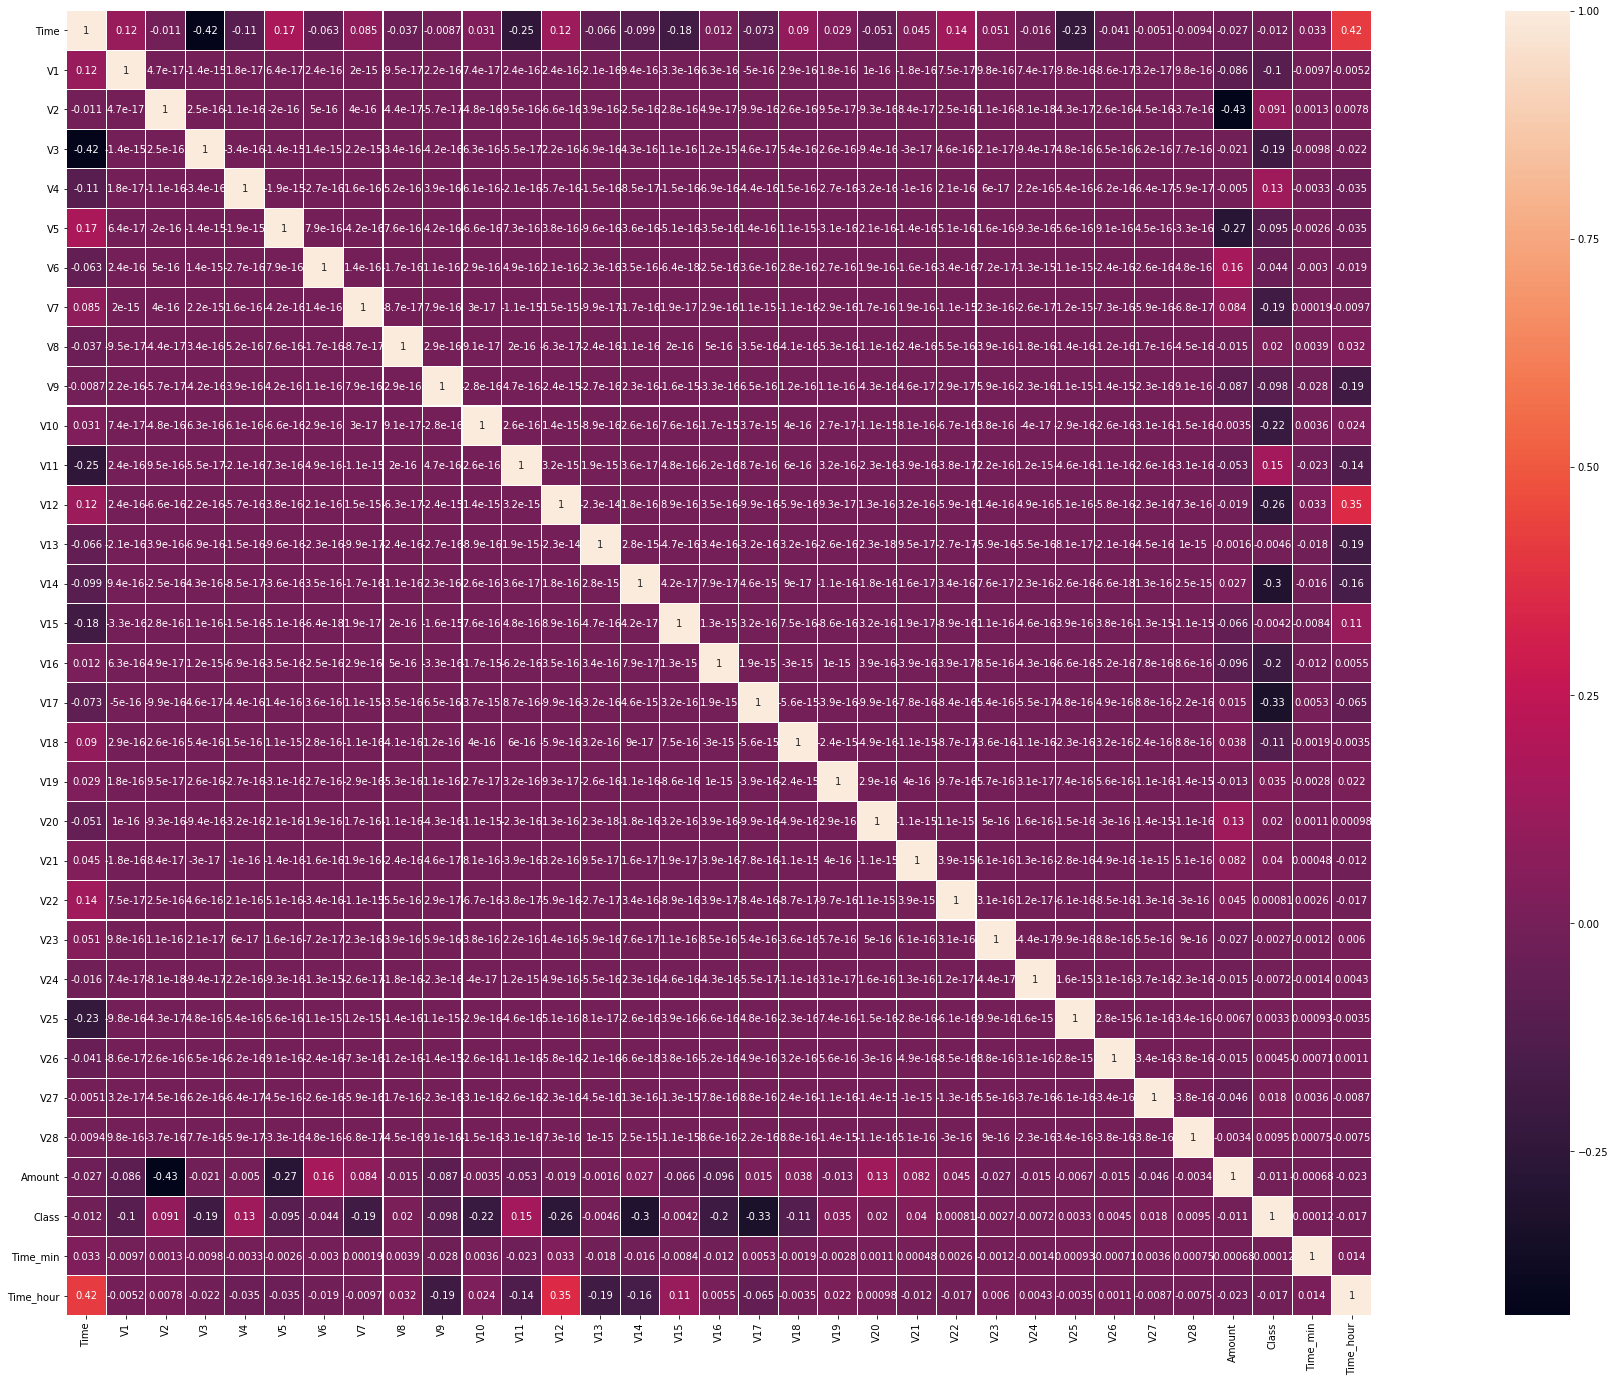

In [15]:
plt.figure(figsize=(48,24))
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True, linecolor='white', annot=True)
plt.show()

### 数据分类不平衡问题

#### 查看数据是否存在分类不平衡的问题

In [16]:
# 查看标签分布情况
class_freq = df['Class'].value_counts()
class_freq

0    284315
1       492
Name: Class, dtype: int64

无欺诈行为样本占比：99.83%
有欺诈行为样本占比：0.17%


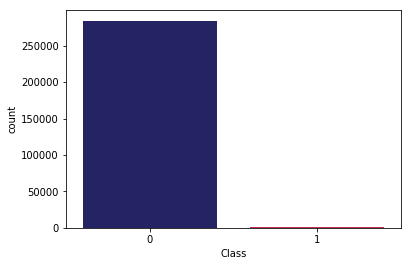

In [17]:
# 不均匀分布可视化
colors = ["#191970", "#DC143C"]
sns.countplot('Class', data=df, palette=colors)
print(f'无欺诈行为样本占比：{round((class_freq[0]/class_freq.sum())*100,2)}%')
print(f'有欺诈行为样本占比：{round((class_freq[1]/class_freq.sum())*100,2)}%')

#### 针对样本类别不平衡问题处理：随机欠取样

* 通过随机抽取与正样本数量一致的负样本，来解决样本中类别不平均的问题

In [18]:
# 打乱数据顺序
df_shuffle = df.copy().sample(frac=1).reset_index(drop=True)
# 抽取全部正样本（492条）
fraud_df = df_shuffle.loc[df_shuffle['Class'] == 1]
# 抽取等量的负样本
non_fraud_df = df_shuffle.loc[df_shuffle['Class'] == 0][:492]
# 合并样本
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
# 再次打乱样本顺序并重新设置index
balanced_sample = normal_distributed_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(balanced_sample['Class'].value_counts())
balanced_sample.head()

1    492
0    492
Name: Class, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Time_min,Time_hour
0,77280.0,1.390787,-0.725698,0.099089,-1.335623,-1.198590,-1.155533,-0.380039,-0.222056,0.479358,...,-0.041332,0.360422,0.687339,-0.511320,0.060939,0.018716,2.272126,0,28,21
1,70828.0,0.196707,1.189757,0.704882,2.891388,0.045555,1.245730,-1.198714,-2.421616,-1.232089,...,-0.005524,-0.814708,0.400924,0.286281,0.135215,0.257315,-0.274437,1,40,19
2,37204.0,1.158825,0.148205,0.239588,0.959277,-0.192804,-0.395777,0.036939,-0.027136,-0.138456,...,-0.188832,-0.004997,0.671632,-0.295215,0.007503,0.012929,3.555348,0,20,10
3,53658.0,-1.739341,1.344521,-0.534379,3.195291,-0.416196,-1.261961,-2.340991,0.713004,-1.416265,...,-0.336640,0.237076,0.246003,-0.044228,0.510729,0.220952,0.000000,1,54,14
4,72824.0,-1.111495,-0.257575,2.250210,1.152671,0.432904,1.254126,-0.584163,-0.609682,1.014602,...,-0.343058,-0.256268,-0.600742,-0.180331,0.026762,-0.358335,3.807329,1,13,20


### 数据预处理

#### 对未经标准化的时间和金额特征进行标准化处理


In [19]:
trans = StandardScaler()
balanced_sample[['Time','Amount','Time_min', 'Time_hour']] = trans.fit_transform(balanced_sample[['Time','Amount','Time_min', 'Time_hour']])
balanced_sample.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Time_min,Time_hour
0,-0.225743,1.390787,-0.725698,0.099089,-1.335623,-1.198590,-1.155533,-0.380039,-0.222056,0.479358,...,-0.041332,0.360422,0.687339,-0.511320,0.060939,0.018716,-0.226342,0,-0.008072,1.267851
1,-0.360579,0.196707,1.189757,0.704882,2.891388,0.045555,1.245730,-1.198714,-2.421616,-1.232089,...,-0.005524,-0.814708,0.400924,0.286281,0.135215,0.257315,-1.363980,1,0.677670,0.952251
2,-1.063263,1.158825,0.148205,0.239588,0.959277,-0.192804,-0.395777,0.036939,-0.027136,-0.138456,...,-0.188832,-0.004997,0.671632,-0.295215,0.007503,0.012929,0.346917,0,-0.465234,-0.467947
3,-0.719403,-1.739341,1.344521,-0.534379,3.195291,-0.416196,-1.261961,-2.340991,0.713004,-1.416265,...,-0.336640,0.237076,0.246003,-0.044228,0.510729,0.220952,-1.241379,1,1.477703,0.163252
4,-0.318866,-1.111495,-0.257575,2.250210,1.152671,0.432904,1.254126,-0.584163,-0.609682,1.014602,...,-0.343058,-0.256268,-0.600742,-0.180331,0.026762,-0.358335,0.459486,1,-0.865250,1.110051


In [20]:
# 保存预处理好的数据
balanced_sample.to_csv('balanced_sample.csv',index=False)

### 模型数据集划分

#### 使用留一法将平衡取样的建模数据集划分为训练集和验证集


In [21]:
# 提取自变量和应变量
X = balanced_sample.drop('Class', axis=1)
y = balanced_sample['Class']
# 使用留一法将数据集按照0.7比0.3将数据集划分成训练集和验证集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f'the shape of X training set is: {X_train.shape}')
print(f'the shape of X testing set is: { X_test.shape}')

the shape of X training set is: (688, 32)
the shape of X testing set is: (296, 32)


### 模型训练

#### 模型训练计划：

* 逻辑回归模型

* 随机森林模型

* xgboost模型

#### 模型调参：

* 检验方法：交叉验证法

* 搜索方法： 网格搜索法

#### 设置交叉验证

In [22]:
# 设置交叉验证
cv = StratifiedKFold(n_splits=3, shuffle=True)

#### 训练逻辑回归模型

In [23]:
# 设定搜索参数范围
log_params = {"penalty": ['l1', 'l2'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# 定义网格搜索器
grid_log_clf = GridSearchCV(LogisticRegression(solver='liblinear'), log_params, cv = cv, n_jobs=16, scoring='roc_auc', verbose=0, refit=True)
# 定义逻辑回归分类器
pipe_logclf = Pipeline([
    ('logistic_grid', grid_log_clf)
])
# 训练模型
pipe_logclf.fit(X_train, y_train)
print('done')

done


查看网格搜索出的最佳超参数

In [24]:
pipe_logclf.named_steps['logistic_grid'].best_params_

{'C': 0.1, 'penalty': 'l1'}

定义一个函数，方便我们查看模型在训练集和验证集上的各种指标

In [25]:
def check_prefprmance(model,X_train, X_test, y_train, y_test):
    y_train_predict = model.predict(X_train)
    print(f'\nOn training datasets:\n')
    print(f'accuracy score is: {accuracy_score(y_train,y_train_predict)}')
    print(f'precision score is: {precision_score(y_train,y_train_predict)}')
    print(f'recall score is: {recall_score(y_train,y_train_predict)}')
    print(f'auc: {roc_auc_score(y_train,y_train_predict)}')
    y_test_predict = model.predict(X_test)
    print(f'\nOn Testing datasets:\n')
    print(f'accuracy score is: {accuracy_score(y_test,y_test_predict)}')
    print(f'precision score is: {precision_score(y_test,y_test_predict)}')
    print(f'recall score is: {recall_score(y_test,y_test_predict)}')
    print(f'auc: {roc_auc_score(y_test,y_test_predict)}')

查看逻辑回归模型的表现

In [26]:
check_prefprmance(pipe_logclf,X_train, X_test, y_train, y_test)


On training datasets:

accuracy score is: 0.9476744186046512
precision score is: 0.99
recall score is: 0.9
auc: 0.9458100558659218

On Testing datasets:

accuracy score is: 0.9391891891891891
precision score is: 0.9736842105263158
recall score is: 0.9135802469135802
auc: 0.9418647503224619


#### 训练随机森林模型

In [27]:
# 定义随机森林模型
rf_model = RandomForestClassifier(criterion='gini',
                                  n_jobs=16,
                                  n_estimators = 1000,
                                  random_state=133)
# 定义需要搜索的参数矩阵
parameters = {'max_features': ['auto',0.5, 0.8, 0.9],
              'max_depth': [3, 6, 9]}
# 定义参数搜索器
rf_grid_search = GridSearchCV(rf_model, parameters, n_jobs=16, cv=cv, scoring='roc_auc',
                                      verbose=0, refit=True)
# 定义随机森林模型
pipe_rfclf = Pipeline([
    ('rf_grid', rf_grid_search)
])
# 训练模型
pipe_rfclf.fit(X_train, y_train)
print('done')

done


查看网格搜索出的最佳超参数

In [28]:
# 查看模型搜索出的最佳参数
pipe_rfclf.named_steps['rf_grid'].best_params_

{'max_depth': 9, 'max_features': 'auto'}

查看随机森林模型的表现

In [29]:
check_prefprmance(pipe_rfclf,X_train, X_test, y_train, y_test)


On training datasets:

accuracy score is: 0.9869186046511628
precision score is: 1.0
recall score is: 0.9727272727272728
auc: 0.9863636363636363

On Testing datasets:

accuracy score is: 0.9493243243243243
precision score is: 0.9741935483870968
recall score is: 0.9320987654320988
auc: 0.9511240095817212


#### 训练xgboost模型

In [30]:
# 定义xgboost模型
xgb_model = xgb.XGBClassifier(objective='binary:hinge',
                             nthread=8,
                             booster='gbtree',
                             n_estimators=500,
                             learning_rate=0.01
                                          
)   
# 定义模型的搜索参数
xgb_paras = {'max_depth': [3, 5],
              'subsample':[0.6, 0.9],
              'colsample_bytree':[0.3, 0.5, 0.6, 0.8],
              'reg_alpha':[0.01, 0.05,0.1, 1, 10]
             }
# 定义网格搜索器
xgb_grid_search = GridSearchCV(xgb_model, xgb_paras, n_jobs=8, cv=cv, scoring='roc_auc',
                                      verbose=2, refit=True)
# 定义xgboost分类模型
pipe_xgbclf = Pipeline([
        ('xgb_clf', xgb_grid_search)
        ])
# 模型训练
pipe_xgbclf.fit(X_train, y_train)
print('done')

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   16.4s
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed:   26.7s finished


done


查看网格搜索出的最佳超参数

In [31]:
pipe_xgbclf.named_steps['xgb_clf'].best_params_

{'colsample_bytree': 0.8, 'max_depth': 3, 'reg_alpha': 0.05, 'subsample': 0.6}

查看xgboost模型的变量相对重要性排行

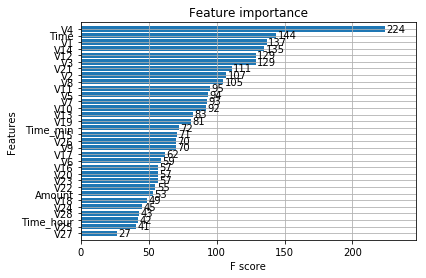

In [32]:
xgb_final = pipe_xgbclf.named_steps['xgb_clf'].best_estimator_
xgb.plot_importance(xgb_final,max_num_features=40,height=0.8)

查看xgboost模型的表现

In [33]:
# 查看xgboost模型的表现
check_prefprmance(pipe_xgbclf,X_train, X_test, y_train, y_test)


On training datasets:

accuracy score is: 0.9898255813953488
precision score is: 1.0
recall score is: 0.9787878787878788
auc: 0.9893939393939394

On Testing datasets:

accuracy score is: 0.9527027027027027
precision score is: 0.9805194805194806
recall score is: 0.9320987654320988
auc: 0.9548553528653033


## 谢谢大家观看

reference：
* https://www.kaggle.com/kabure/credit-card-fraud-prediction-rf-smote
* https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets